# Pacific Union College Example

### Create a FastFuels domain from your burn unit

In [1]:
import geopandas as gpd
from shapely.geometry import box
import pandas as pd

In [2]:
# set the parameters to create the fastfuels tile
boundary = gpd.read_file('boundary.geojson')
boundary = boundary.to_crs(5070)

buffer_size = 50 #meters

boundary_bounds = box(*boundary.total_bounds)
boundary_bounds = boundary_bounds.buffer(buffer_size, join_style = 'mitre')

df = pd.DataFrame({'id': ['0'], 'geometry': [boundary_bounds]})

ff_domain = gpd.GeoDataFrame(df, geometry='geometry', crs=boundary.crs)
ff_domain.to_file('ff_domain.geojson')

### Search STAC to see what data is available in the FastFuels domain

In [29]:
import json
from pathlib import Path

from pystac.client import Client
import geopandas as gpd


In [2]:
# Load the area of interest

geojson_path = Path("ff_domain.geojson")
gdf = gpd.read_file(geojson_path)

# Create connection to STAC Catalog

stac_url = 'https://ndp-test.sdsc.edu/stac'
catalog = Client.open(stac_url)

# Search STAC for items interesecting with area of interest
search_results = catalog.search(
    bbox=gdf.total_bounds
)

# Display matching items
print('Catalog entries in area of interest:')
for item in search_results.items():
    print(item.id)



Catalog entries in area of interest:
CALNU-0039-20250810
CALNU-0037-20250810
CALNU-0036-20250810
CALNU-0034-20250810
CALNU-0042-20250809
CALNU-0041-20250809
CALNU-0040-20250809
CALNU-0038-20250809
CALNU-0033-20250809
CALNU-0032-20250808
CALNU-0031-20250808
CALNU-0029-20250808
CALNU-0028-20250808
CALNU-0046-20250806
CALNU-0045-20250806
CALNU-0044-20250806
CALNU-0005-20250806
CALNU-0004-20250806
gdam
CALNU-0032-20241110
CALNU-0029-20241110
CALNU-0028-20241110
CALNU-0039-20241109
CALNU-0037-20241109
CALNU-0036-20241109
CALNU-0034-20241109
CALNU-0033-20241109
CALNU-0031-20241109
CALNU-0045-20241108
CALNU-0042-20241108
CALNU-0041-20241108
CALNU-0040-20241108
CALNU-0038-20241108
CALNU-0046-20241107
CALNU-0044-20241107
meta-canopy-height-maps
landfire-fccs-2024
landfire-fbfm-sb40-2024
landfire-fccs-2023
landfire-fbfm-sb40-2023
usda-treemap-2022
landfire-fccs-2022
landfire-fbfm-sb40-2022
usda-treemap-2020
usda-treemap-2016
california_statewide_30m_slope_epsg3310
california_statewide_30m_skewne

### Generate FastFuels Tiles

In [3]:
!pip install fastfuels-sdk --upgrade

In [7]:
import os
os.environ["FASTFUELS_API_KEY"] = "test-api-key"
from fastfuels_sdk.domains import Domain
from fastfuels_sdk.features import Features
from fastfuels_sdk.grids import TopographyGridBuilder
from fastfuels_sdk.inventories import Inventories
from fastfuels_sdk.grids import TreeGridBuilder
from fastfuels_sdk.grids import SurfaceGridBuilder
from fastfuels_sdk.grids import Grids
from fastfuels_sdk.pointclouds import PointClouds

import geopandas as gpd
from pathlib import Path



In [8]:
from fastfuels_sdk import export_roi

In [9]:
# set the parameters to create the fastfuels tile
boundary = gpd.read_file('ff_domain.geojson')
boundary = boundary.to_crs(5070)
site_name = 'sitename'
product="FBFM40"
version='2022'
interpolation_method='zipper'
curing_live_herbaceous=0.25
curing_live_woody=0.1
groups = ['oneHour']
feature_masks=["road", "water"]
remove_non_burnable=["NB1", "NB2"]
uniform_fuel_moisture_value=15
live_fuel_moisture=106
use_tree_inventory = False
tree_inventory_path = None
horizontal_resolution=2.0
vertical_resolution=1.0


In [10]:
def create_fastfuels(boundary, site_name, product, 
                    version, interpolation_method, 
                    curing_live_herbaceous, curing_live_woody, 
                    groups, feature_masks, remove_non_burnable, 
                    uniform_fuel_moisture_value, grid_data_zip_path, live_fuel_moisture,
                    tree_inventory_save_path, grid_data_qf_path,
                    meta = False, als = False, tree_inventory = False, tree_inventory_path = None,
                    horizontal_resolution=2.0, vertical_resolution=1.0):
    # Create domain
    domain = Domain.from_geodataframe(
    geodataframe=boundary,
    name=site_name,
    description=f"domain of {site_name}",
    horizontal_resolution=horizontal_resolution,  # Use the argument
    vertical_resolution=vertical_resolution       # Use the argument
    )
    print(f"Created domain with ID: {domain.id}")
    
    
    # Initialize Features for our domain
    features = Features.from_domain_id(domain.id)
    
    # Initialize grids for our domain
    grids = Grids.from_domain_id(domain.id)
    
    # Create features from OpenStreetMap
    road_feature = features.create_road_feature_from_osm()
    water_feature = features.create_water_feature_from_osm()
    
    # Wait for features to be ready
    road_feature.wait_until_completed()
    water_feature.wait_until_completed()
    
    print("created road and water")
    
    # Create a feature grid with roads and water bodies
    feature_grid = grids.create_feature_grid(
        attributes=["road", "water"]
    )
    feature_grid.wait_until_completed()
    print("created feature grid")
    
    topography_grid = (
        TopographyGridBuilder(domain_id=domain.id)
        .with_elevation_from_3dep()
        .with_slope_from_3dep()
        .with_aspect_from_3dep()
        .build()
    )
    
    topography_grid.wait_until_completed()
    print("created topo")
    
    # if tree meta flag is true (you want to use a meta as the tree inventory)
    if meta:
        tree_inventory = Inventories.from_domain_id(
            domain.id
        ).create_tree_inventory_from_treemap(
            feature_masks=feature_masks,
            canopy_height_map_source = 'Meta2024'
        )
        tree_inventory.wait_until_completed(step = 1, verbose = True)
        print("created tree")
    elif als:
        als_pointcloud = (
            PointClouds.from_domain_id(domain.id)
            .create_als_point_cloud(sources=["3DEP"])
        )
        als_pointcloud.wait_until_completed(step=1, verbose=True)
        print("created als point cloud")

        tree_inventory = Inventories.from_domain_id(
            domain.id
        ).create_tree_inventory_from_point_cloud()
        tree_inventory.wait_until_completed(step = 1, verbose = True)
    
    
    # else Create tree inventory
    else:
        if use_tree_inventory:
            tree_inventory = Inventories.from_domain_id(
                        domain.id
                    ).create_tree_inventory_from_file_upload(
                        # feature_masks=feature_masks,
                        file_path=(tree_inventory_path)
                    )
            tree_inventory.wait_until_completed(step = 1, verbose = True)
            print("created tree using csv tree inventory")
            
        else:
            tree_inventory = Inventories.from_domain_id(
                domain.id
            ).create_tree_inventory_from_treemap(
                feature_masks=feature_masks
            )
            tree_inventory.wait_until_completed(step = 1, verbose = True)
            print("created tree")

    #export tree inventory
    export = tree_inventory.create_export("csv")  # or "parquet" or "geojson"
    export = export.wait_until_completed()
    
    # Download to specific file
    export.to_file(tree_inventory_save_path)
    
    # Create tree grid
    tree_grid = (
        TreeGridBuilder(domain_id=domain.id)
        .with_bulk_density_from_tree_inventory()
        .with_spcd_from_tree_inventory()
        .with_uniform_fuel_moisture(live_fuel_moisture)
        .build()
    )
    tree_grid.wait_until_completed(step = 1, verbose = True)
    
    print("created treegrid")
    
    # Create surface grid
    if product == "FBFM40":
        surface_grid = (
            SurfaceGridBuilder(domain_id=domain.id)
            .with_fuel_load_from_landfire(
                product=product,
                version=version,
                interpolation_method=interpolation_method,
                curing_live_herbaceous=curing_live_herbaceous,
                curing_live_woody=curing_live_woody,
                groups=groups,
                feature_masks=feature_masks,
                remove_non_burnable=remove_non_burnable,
            )
            .with_fuel_depth_from_landfire(
                product=product,
                version=version,
                interpolation_method=interpolation_method,
                feature_masks=feature_masks,
                remove_non_burnable=remove_non_burnable,
            )
            .with_uniform_fuel_moisture(
                value=uniform_fuel_moisture_value,
                feature_masks=feature_masks
            )
            .build()
        )
    elif product == "FCCS":
        surface_grid = (
            SurfaceGridBuilder(domain_id=domain.id)
            .with_fuel_load_from_landfire(
                product=product,
                version=version,
                interpolation_method=interpolation_method,
                groups=groups,
                feature_masks=feature_masks,
            )
            .with_fuel_depth_from_landfire(
                product=product,
                version=version,
                interpolation_method=interpolation_method,
                feature_masks=feature_masks,
            )
            .with_uniform_fuel_moisture(
                value=uniform_fuel_moisture_value,
                feature_masks=feature_masks
            )
            .build()
        )
    surface_grid.wait_until_completed(step = 1, verbose = True)
    print("created surface")
    
    # Create the export
    export = grids.create_export("zarr") #"zarr" or "QUICFire"
    
    # Wait for the export to complete
    export.wait_until_completed()
    print('exported to zarr')
    
    # Save to a file
    export.to_file(grid_data_zip_path)

    export = grids.create_export("QUIC-Fire") #"zarr" or "QUIC-Fire"
    
    # Wait for the export to complete
    export.wait_until_completed()
    print('exported to QUIC-Fire')
    # Save to a file
    export.to_file(grid_data_qf_path)

#### Workflow 1: TreeMap Plot Imputation + LANDFIRE FBFM40
Create a tree inventory using TreeMap's nationwide coverage with default settings.


In [11]:
grid_data_zip_path = 'workflow_1_treemap_fbfm40.zarr.zip'
grid_data_qf_path = 'workflow_1_treemap_fbfm40.qf.zip'
tree_inventory_save_path = 'tree_inventory_1_export.csv'

create_fastfuels(boundary, site_name, product, 
                    version, interpolation_method, 
                    curing_live_herbaceous, curing_live_woody, 
                    groups, feature_masks, remove_non_burnable, 
                    uniform_fuel_moisture_value, grid_data_zip_path, live_fuel_moisture,
                    tree_inventory_save_path, grid_data_qf_path)


Created domain with ID: 06a15f8a18fd4e3889171d0818a3c380
created road and water
created feature grid
created topo
Tree inventory has status `JobStatus.PENDING` (1.00s)
Tree inventory has status `JobStatus.PENDING` (2.00s)
Tree inventory has status `JobStatus.PENDING` (3.00s)
Tree inventory has status `JobStatus.PENDING` (4.00s)
Tree inventory has status `JobStatus.PENDING` (5.00s)
Tree inventory has status `JobStatus.PENDING` (6.00s)
Tree inventory has status `JobStatus.PENDING` (7.00s)
Tree inventory has status `JobStatus.PENDING` (8.00s)
Tree inventory has status `JobStatus.PENDING` (9.00s)
Tree inventory has status `JobStatus.PENDING` (10.00s)
Tree inventory has status `JobStatus.PENDING` (11.00s)
Tree inventory has status `JobStatus.PENDING` (12.00s)
Tree inventory has status `JobStatus.PENDING` (13.00s)
Tree inventory has status `JobStatus.PENDING` (14.00s)
Tree inventory has status `JobStatus.PENDING` (15.00s)
Tree inventory has status `JobStatus.PENDING` (16.00s)
Tree inventory 


#### Workflow 2: Data Fusion (TreeMap + Meta2024) + LANDFIRE FBFM40

Create a tree inventory using TreeMap with high-resolution Meta2024 canopy height data for improved tree height estimates.


In [12]:
grid_data_zip_path = 'workflow_2_meta_fbfm40.zarr.zip' #'/path/to/.zip/file' #fuels-array.zip - this is what you want to export the zarr file as
grid_data_qf_path = 'workflow_2_meta_fbfm40.qf.zip'
tree_inventory_save_path = 'tree_inventory_2_export.csv'
meta = True

create_fastfuels(boundary, site_name, product, 
                    version, interpolation_method, 
                    curing_live_herbaceous, curing_live_woody, 
                    groups, feature_masks, remove_non_burnable, 
                    uniform_fuel_moisture_value, grid_data_zip_path, live_fuel_moisture,
                    tree_inventory_save_path, grid_data_qf_path,
                    meta = meta)

Created domain with ID: 538f297ef1bb411e867f7a40948bf978
created road and water
created feature grid
created topo
Tree inventory has status `JobStatus.PENDING` (1.00s)
Tree inventory has status `JobStatus.PENDING` (2.00s)
Tree inventory has status `JobStatus.PENDING` (3.00s)
Tree inventory has status `JobStatus.PENDING` (4.00s)
Tree inventory has status `JobStatus.PENDING` (5.00s)
Tree inventory has status `JobStatus.PENDING` (6.00s)
Tree inventory has status `JobStatus.PENDING` (7.00s)
Tree inventory has status `JobStatus.PENDING` (8.00s)
Tree inventory has status `JobStatus.PENDING` (9.00s)
Tree inventory has status `JobStatus.PENDING` (10.00s)
Tree inventory has status `JobStatus.PENDING` (11.00s)
Tree inventory has status `JobStatus.PENDING` (12.00s)
Tree inventory has status `JobStatus.PENDING` (13.00s)
Tree inventory has status `JobStatus.PENDING` (14.00s)
Tree inventory has status `JobStatus.PENDING` (15.00s)
Tree inventory has status `JobStatus.PENDING` (16.00s)
Tree inventory 

#### Workflow 3: 3DEP ALS + LANDFIRE FBFM40

In [13]:
grid_data_zip_path = 'workflow_3_als_fbfm40.zarr.zip'
grid_data_qf_path = 'workflow_3_als_fbfm40.qf.zip'
tree_inventory_save_path = 'tree_inventory_3_export.csv'
als=True

create_fastfuels(boundary, site_name, product,
                    version, interpolation_method,
                    curing_live_herbaceous, curing_live_woody,
                    groups, feature_masks, remove_non_burnable,
                    uniform_fuel_moisture_value, grid_data_zip_path, live_fuel_moisture,
                    tree_inventory_save_path, grid_data_qf_path,
                    als=als)

Created domain with ID: ca9ff57690004be5b1c5ac6f8d0f07f8
created road and water
created feature grid
created topo
ALS point cloud has status `JobStatus.PENDING` (1.00s)
ALS point cloud has status `JobStatus.PENDING` (2.00s)
ALS point cloud has status `JobStatus.PENDING` (3.00s)
ALS point cloud has status `JobStatus.PENDING` (4.00s)
ALS point cloud has status `JobStatus.PENDING` (5.00s)
ALS point cloud has status `JobStatus.PENDING` (6.00s)
ALS point cloud has status `JobStatus.PENDING` (7.00s)
ALS point cloud has status `JobStatus.PENDING` (8.00s)
ALS point cloud has status `JobStatus.PENDING` (9.00s)
ALS point cloud has status `JobStatus.PENDING` (10.00s)
ALS point cloud has status `JobStatus.PENDING` (11.00s)
ALS point cloud has status `JobStatus.PENDING` (12.00s)
ALS point cloud has status `JobStatus.PENDING` (13.00s)
ALS point cloud has status `JobStatus.PENDING` (14.00s)
ALS point cloud has status `JobStatus.PENDING` (15.00s)
ALS point cloud has status `JobStatus.PENDING` (16.00s)

#### Workflow 4: TreeMap + LANDFIRE FCCS


In [14]:
grid_data_zip_path = 'workflow_4_treemap_fccs.zarr.zip'
grid_data_qf_path = 'workflow_4_treemap_fccs.qf.zip'
tree_inventory_save_path = 'tree_inventory_4_export.csv'
product="FCCS"
version='2023'

create_fastfuels(boundary, site_name, product,
                    version, interpolation_method,
                    curing_live_herbaceous, curing_live_woody,
                    groups, feature_masks, remove_non_burnable,
                    uniform_fuel_moisture_value, grid_data_zip_path, live_fuel_moisture,
                    tree_inventory_save_path, grid_data_qf_path)


Created domain with ID: 1244e36c5dca4821a87d9b50c3bb4993
created road and water
created feature grid
created topo
Tree inventory has status `JobStatus.PENDING` (1.00s)
Tree inventory has status `JobStatus.PENDING` (2.00s)
Tree inventory has status `JobStatus.PENDING` (3.00s)
Tree inventory has status `JobStatus.PENDING` (4.00s)
Tree inventory has status `JobStatus.PENDING` (5.00s)
Tree inventory has status `JobStatus.PENDING` (6.00s)
Tree inventory has status `JobStatus.PENDING` (7.00s)
Tree inventory has status `JobStatus.PENDING` (8.00s)
Tree inventory has status `JobStatus.PENDING` (9.00s)
Tree inventory has status `JobStatus.PENDING` (10.00s)
Tree inventory has status `JobStatus.PENDING` (11.00s)
Tree inventory has status `JobStatus.PENDING` (12.00s)
Tree inventory has status `JobStatus.PENDING` (13.00s)
Tree inventory has status `JobStatus.PENDING` (14.00s)
Tree inventory has status `JobStatus.PENDING` (15.00s)
Tree inventory has status `JobStatus.PENDING` (16.00s)
Tree inventory 

#### Workflow 5: TreeMap + Meta + LANDFIRE FCCS

In [16]:
grid_data_zip_path = 'workflow_5_meta_fccs.zarr.zip'
grid_data_qf_path = 'workflow_5_meta_fccs.qf.zip'
tree_inventory_save_path = 'tree_inventory_5_export.csv'
product="FCCS"
meta=True
version='2023'

create_fastfuels(boundary, site_name, product,
                    version, interpolation_method,
                    curing_live_herbaceous, curing_live_woody,
                    groups, feature_masks, remove_non_burnable,
                    uniform_fuel_moisture_value, grid_data_zip_path, live_fuel_moisture,
                    tree_inventory_save_path, grid_data_qf_path, meta=meta)


Created domain with ID: 1ff14f5266c54d5595008a0bd18a1467
created road and water
created feature grid
created topo
Tree inventory has status `JobStatus.PENDING` (1.00s)
Tree inventory has status `JobStatus.PENDING` (2.00s)
Tree inventory has status `JobStatus.PENDING` (3.00s)
Tree inventory has status `JobStatus.PENDING` (4.00s)
Tree inventory has status `JobStatus.PENDING` (5.00s)
Tree inventory has status `JobStatus.PENDING` (6.00s)
Tree inventory has status `JobStatus.PENDING` (7.00s)
Tree inventory has status `JobStatus.PENDING` (8.00s)
Tree inventory has status `JobStatus.PENDING` (9.00s)
Tree inventory has status `JobStatus.PENDING` (10.00s)
Tree inventory has status `JobStatus.PENDING` (11.00s)
Tree inventory has status `JobStatus.PENDING` (12.00s)
Tree inventory has status `JobStatus.PENDING` (13.00s)
Tree inventory has status `JobStatus.PENDING` (14.00s)
Tree inventory has status `JobStatus.PENDING` (15.00s)
Tree inventory has status `JobStatus.PENDING` (16.00s)
Tree inventory 

#### Workflow 6: ALS + LANDFIRE FCCS

In [17]:
grid_data_zip_path = 'workflow_6_als_fccs.zarr.zip'
grid_data_qf_path = 'workflow_6_als_fccs.qf.zip'
tree_inventory_save_path = 'tree_inventory_6_export.csv'
product="FCCS"
als=True
version='2023'

create_fastfuels(boundary, site_name, product,
                    version, interpolation_method,
                    curing_live_herbaceous, curing_live_woody,
                    groups, feature_masks, remove_non_burnable,
                    uniform_fuel_moisture_value, grid_data_zip_path, live_fuel_moisture,
                    tree_inventory_save_path, grid_data_qf_path, als=als)



Created domain with ID: 802e10f39a994b94a3c6b16d1082f103
created road and water
created feature grid
created topo
ALS point cloud has status `JobStatus.PENDING` (1.00s)
ALS point cloud has status `JobStatus.PENDING` (2.00s)
ALS point cloud has status `JobStatus.PENDING` (3.00s)
ALS point cloud has status `JobStatus.PENDING` (4.00s)
ALS point cloud has status `JobStatus.PENDING` (5.00s)
ALS point cloud has status `JobStatus.PENDING` (6.00s)
ALS point cloud has status `JobStatus.PENDING` (7.00s)
ALS point cloud has status `JobStatus.PENDING` (8.00s)
ALS point cloud has status `JobStatus.PENDING` (9.00s)
ALS point cloud has status `JobStatus.PENDING` (10.00s)
ALS point cloud has status `JobStatus.PENDING` (11.00s)
ALS point cloud has status `JobStatus.PENDING` (12.00s)
ALS point cloud has status `JobStatus.PENDING` (13.00s)
ALS point cloud has status `JobStatus.PENDING` (14.00s)
ALS point cloud has status `JobStatus.PENDING` (15.00s)
ALS point cloud has status `JobStatus.PENDING` (16.00s)

### Send to BurnPro3D

In [18]:
import bp3d
import shutil
import zipfile
from scipy.io import FortranFile 
import numpy as np
import zarr
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO



In [19]:
import os
gui_dir = str(os.getcwd()) + '/'
user = 'username' #BP3D username
password = 'password' #BP3D password


wind_speed = [2] #list of wind speeds in mph
wind_speed = [ws/2.237 for ws in wind_speed] #change from m/s to mph

wind_direction = [270] #list of wind directions
fuel_moisture = [0.10] #fine dead fuel moisture
lfm = [1.06] #live fuel moisture


In [23]:
new_zarr = grid_data_zip_path

destination_name = r'fuel-array.zip'

def prep_bp3d(dir_path, zipped_dat, zipped_zarr, ensemble_name, 
                 user, password, destination_name = r'fuel-array.zip'):

    # unzip and extract .dat files
    
    extract_to_folder = dir_path
    
    # Unzip the file
    with zipfile.ZipFile(zipped_dat, 'r') as zip_ref:
        print(f"Extracting all files to '{extract_to_folder}'...")
        zip_ref.extractall(extract_to_folder)
        print('Extraction complete.')

    # make the fuel-array the new zarr file that was created through fastfuels
    gui_dir = dir_path #str(os.getcwd()) + '/'
    
    shutil.copy2(zipped_zarr, destination_name)
    print(f"File '{zipped_zarr}' copied successfully to '{destination_name}'")
    
    
    # set up the BP3D Client
    c = bp3d.Client(user=user, password=password)
    
    # get ready to import project from GUI Folder
    qf_ensemble = c.import_project(name = ensemble_name, path = gui_dir)
    

    # # create the ignition pattern to the ensemble

    ign = qf_ensemble.add_ignition(
            firing_direction=250,
            firing_technique='strip',
            ignitors=3,
            gap_length=3,
            dash_length=3,
            velocity_mph=1.0,
            offset=10,
            depth=10,
            pass_distance=0,
            stagger=10,
            clockwise=True,
            side='left',
            blackline=10,
            control_line=2,
            metric=True
            )
    
    # set the environmental variables and desired output 
    qf_ensemble.add_runs(
                    ignition=ign,
                    wind_speed=wind_speed,
                    wind_direction=wind_direction,
                    replace=True,
                    surface_moisture= fuel_moisture,
                    canopy_moisture= lfm, 
                    quicfire_version='6.1.2-dist',
                    output = {'steps_fire': 300, 'fuels_dens':True}
                    )

    
    # run ensembles
    # qf_ensemble.execute()
    return(qf_ensemble)

In [24]:
dir_path =str(os.getcwd()) + '/'


In [27]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d %H:%M')

#send to bp3d
ensemble_name1 = f'treemap_landfire PUC {date}'
workflow1 = prep_bp3d(dir_path, r'workflow_1_treemap_fbfm40.qf.zip', r'workflow_1_treemap_fbfm40.zarr.zip', ensemble_name1, user, password, destination_name = r'fuel-array.zip')

ensemble_name2 = f'meta_treemap_landfire PUC {date}'
workflow2 = prep_bp3d(dir_path, r'workflow_2_meta_fbfm40.qf.zip', r'workflow_2_meta_fbfm40.zarr.zip', ensemble_name2, user, password, destination_name = r'fuel-array.zip')

# ensemble_name3 = f'ALS_landfire PUC {date}'
# workflow3 = prep_bp3d(dir_path, r'workflow_3_als_fbfm40.qf.zip', r'workflow_3_als_fbfm40.zarr.zip', ensemble_name3, user, password, destination_name = r'fuel-array.zip')

ensemble_name4 = f'treemap_fccs PUC {date}'
workflow4 = prep_bp3d(dir_path, r'workflow_4_treemap_fccs.qf.zip', r'workflow_4_treemap_fccs.zarr.zip', ensemble_name4, user, password, destination_name = r'fuel-array.zip')

ensemble_name5 = f'meta_treemap_fccs PUC {date}'
workflow5 = prep_bp3d(dir_path, r'workflow_5_meta_fccs.qf.zip', r'workflow_5_meta_fccs.zarr.zip', ensemble_name5, user, password, destination_name = r'fuel-array.zip')

# ensemble_name6 = f'ALS_fccs PUC {date}'
# workflow6 = prep_bp3d(dir_path,r'workflow_6_als_fccs.qf.zip', r'workflow_6_als_fccs.zarr.zip', ensemble_name6, user, password, destination_name = r'fuel-array.zip')


Extracting all files to '/Users/leticia/Documents/OCT_2025/Mac_GUI/projects/puc_small/'...
Extraction complete.
File 'workflow_1_treemap_fbfm40.zarr.zip' copied successfully to 'fuel-array.zip'
collecting fuel files for upload
found treesrhof.dat
found treesfueldepth.dat
found treesmoist.dat
found ff_pad.geojson
found ff_blackline.geojson
found fuel-array.zip
not found gridlist (optional)
found fastfuels_topo.dat
found treesss.dat
found GUIdata.json
uploading fuels. this can take awhile.
Extracting all files to '/Users/leticia/Documents/OCT_2025/Mac_GUI/projects/puc_small/'...
Extraction complete.
File 'workflow_2_meta_fbfm40.zarr.zip' copied successfully to 'fuel-array.zip'
collecting fuel files for upload
found treesrhof.dat
found treesfueldepth.dat
found treesmoist.dat
found ff_pad.geojson
found ff_blackline.geojson
found fuel-array.zip
not found gridlist (optional)
found fastfuels_topo.dat
found treesss.dat
found GUIdata.json
uploading fuels. this can take awhile.
Extracting all fi

#### Surface Fuels
Surface fuels are from LANDFIRE and FCCS

In [28]:
# check the fuels, etc through bp3d

c = bp3d.Client(user=user, password=password)

plan = c.plan(ensemble_name2)
ens = plan.ensemble(ensemble_name2)
runs = ens.runs_df

fuel = ens.fuels[0]
lf_fueldepth = fuel.viz('png', 'fuel_depth', #"'all', 'bulk_density', 'fbfm', 'fuel_depth', 'loading', 'moisture', 'sav' or 'elevation',  'chm', 'dbh' or 'horizontal_trees_bulk_density'
   depth=0,
   use_cache=False,
   show={
       'legend': True,
   })
lf_fueldepth.sort()

lf_fuelloading = fuel.viz('png', 'loading', #"'all', 'bulk_density', 'fbfm', 'fuel_depth', 'loading', 'moisture', 'sav' or 'elevation',  'chm', 'dbh' or 'horizontal_trees_bulk_density'
   depth=0,
   use_cache=False,
   show={
       'legend': True,
   })
lf_fuelloading.sort()

In [29]:
# check the fuels, etc through bp3d

c = bp3d.Client(user=user, password=password)

plan = c.plan(ensemble_name4)
ens = plan.ensemble(ensemble_name4)
runs = ens.runs_df

fuel = ens.fuels[0]
fccs_fueldepth = fuel.viz('png', 'fuel_depth', #"'all', 'bulk_density', 'fbfm', 'fuel_depth', 'loading', 'moisture', 'sav' or 'elevation',  'chm', 'dbh' or 'horizontal_trees_bulk_density'
   depth=0,
   use_cache=False,
   show={
       'legend': True,
   })
fccs_fueldepth.sort()

fccs_fuelloading = fuel.viz('png', 'loading', #"'all', 'bulk_density', 'fbfm', 'fuel_depth', 'loading', 'moisture', 'sav' or 'elevation',  'chm', 'dbh' or 'horizontal_trees_bulk_density'
   depth=0,
   use_cache=False,
   show={
       'legend': True,
   })
fccs_fuelloading.sort()

(-0.5, 449.5, 490.5, -0.5)

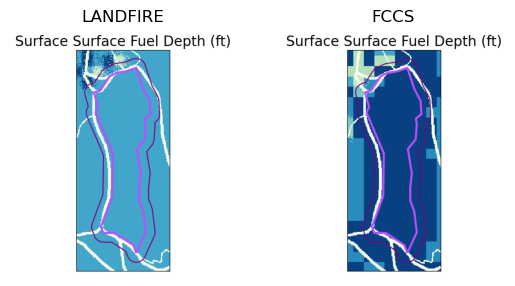

In [30]:
response_a = requests.get(lf_fueldepth[0])
response_b = requests.get(fccs_fueldepth[0])

image_a = Image.open(BytesIO(response_a.content))
image_b = Image.open(BytesIO(response_b.content))

img_A = np.array(image_a)
img_B = np.array(image_b)

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[0].set_title('LANDFIRE')
ax[0].axis('off')
ax[1].imshow(img_B)
ax[1].set_title('FCCS')
ax[1].axis('off')


(-0.5, 402.5, 490.5, -0.5)

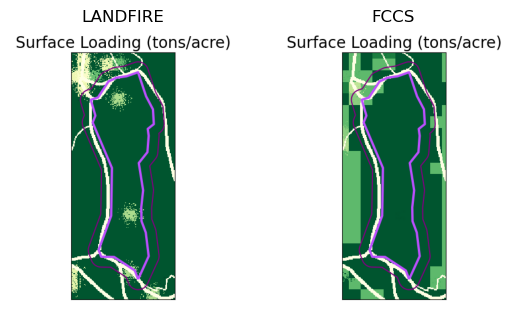

In [31]:
response_a = requests.get(lf_fuelloading[0])
response_b = requests.get(fccs_fuelloading[0])

image_a = Image.open(BytesIO(response_a.content))
image_b = Image.open(BytesIO(response_b.content))

img_A = np.array(image_a)
img_B = np.array(image_b)

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[0].set_title('LANDFIRE')
ax[0].axis('off')
ax[1].imshow(img_B)
ax[1].set_title('FCCS')
ax[1].axis('off')


#### Canopy Fuels
##### Canopy Height Model

In [32]:
# check the canopy height model, etc through bp3d

c = bp3d.Client(user=user, password=password)

plan = c.plan(ensemble_name2)
ens = plan.ensemble(ensemble_name2)
runs = ens.runs_df

fuel = ens.fuels[0]
treemap_chm = fuel.viz('png', 'chm', #"'all', 'bulk_density', 'fbfm', 'fuel_depth', 'loading', 'moisture', 'sav' or 'elevation',  'chm', 'dbh' or 'horizontal_trees_bulk_density'
   depth=0,
   use_cache=False,
   show={
       'legend': True,
   })
treemap_chm.sort()

c = bp3d.Client(user=user, password=password)

plan = c.plan(ensemble_name5)
ens = plan.ensemble(ensemble_name5)
runs = ens.runs_df

fuel = ens.fuels[0]
treemap_meta_chm = fuel.viz('png', 'chm', #"'all', 'bulk_density', 'fbfm', 'fuel_depth', 'loading', 'moisture', 'sav' or 'elevation',  'chm', 'dbh' or 'horizontal_trees_bulk_density'
   depth=0,
   use_cache=False,
   show={
       'legend': True,
   })
treemap_meta_chm.sort()

(-0.5, 745.5, 490.5, -0.5)

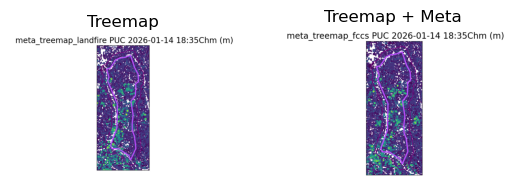

In [33]:
response_a = requests.get(treemap_chm[0])
response_b = requests.get(treemap_meta_chm[0])

image_a = Image.open(BytesIO(response_a.content))
image_b = Image.open(BytesIO(response_b.content))

img_A = np.array(image_a)
img_B = np.array(image_b)

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[0].set_title('Treemap')
ax[0].axis('off')

ax[1].imshow(img_B)
ax[1].set_title('Treemap + Meta')
ax[1].axis('off')


### Vertical Profile Distribution

In [34]:
# check the canopy height model, etc through bp3d

c = bp3d.Client(user=user, password=password)

plan = c.plan(ensemble_name2)
ens = plan.ensemble(ensemble_name2)
runs = ens.runs_df

fuel = ens.fuels[0]
treemap_dist = fuel.viz('png', 'vertical_trees_bulk_density')
treemap_dist.sort()

c = bp3d.Client(user=user, password=password)

plan = c.plan(ensemble_name5)
ens = plan.ensemble(ensemble_name5)
runs = ens.runs_df

fuel = ens.fuels[0]
treemap_meta_dist = fuel.viz('png', 'vertical_trees_bulk_density')
treemap_meta_dist.sort()

(-0.5, 650.5, 490.5, -0.5)

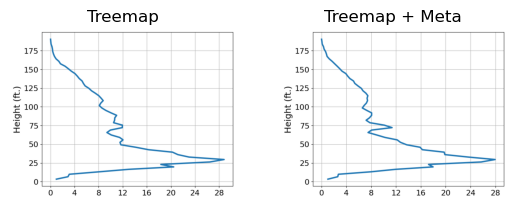

In [35]:
response_a = requests.get(treemap_dist[0])
response_b = requests.get(treemap_meta_dist[0])

image_a = Image.open(BytesIO(response_a.content))
image_b = Image.open(BytesIO(response_b.content))

img_A = np.array(image_a)
img_B = np.array(image_b)

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[0].set_title('Treemap')
ax[0].axis('off')

ax[1].imshow(img_B)
ax[1].set_title('Treemap + Meta')
ax[1].axis('off')


### Compare Tree Inventories

#### Tree inventories

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [37]:
# read in the treelists from fastfuels
fftl_treemap = pd.read_csv('tree_inventory_1_export.csv')
fftl_meta = pd.read_csv('tree_inventory_2_export.csv')
fftl_als = pd.read_csv('tree_inventory_3_export.csv')

fftl_treemap_gpd = gpd.GeoDataFrame(fftl_treemap, geometry = gpd.points_from_xy(fftl_treemap.X, fftl_treemap.Y), crs = 5070)
fftl_meta_gpd = gpd.GeoDataFrame(fftl_meta, geometry = gpd.points_from_xy(fftl_meta.X, fftl_meta.Y), crs = 5070)
fftl_als_gpd = gpd.GeoDataFrame(fftl_als, geometry = gpd.points_from_xy(fftl_als.X, fftl_als.Y), crs = 3857)
fftl_als_gpd = fftl_als_gpd.to_crs(5070)

# filter the trees in the burn unit
boundary = gpd.read_file('boundary.geojson')
boundary_5070 = boundary.to_crs(5070)

fftl_treemap_gpd = fftl_treemap_gpd.sjoin(boundary_5070)
fftl_meta_gpd = fftl_meta_gpd.sjoin(boundary_5070)
fftl_als_gpd = fftl_als_gpd.sjoin(boundary_5070)


#### Species Distribution

In [38]:
treespeciescode = pd.read_csv('FIATreeSpeciesCode.csv')

fftl_treemap_gpd = fftl_treemap_gpd.merge(treespeciescode, on = 'SPCD')
fftl_meta_gpd = fftl_meta_gpd.merge(treespeciescode, on = 'SPCD')
fftl_als_gpd = fftl_als_gpd.merge(treespeciescode, on = 'SPCD')


/var/folders/rp/zdr20wpx60j7227xn_x7mjqc0000gn/T/ipykernel_71624/3194920398.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Pastel2')


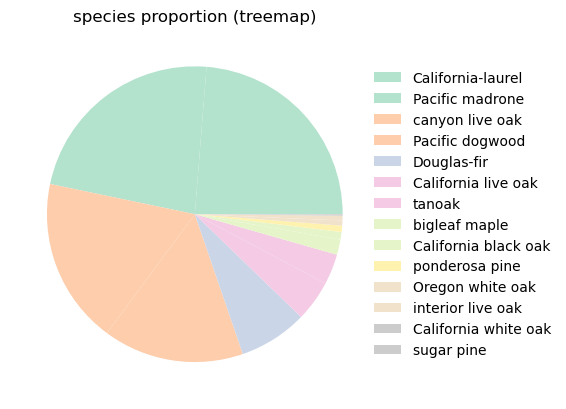

In [39]:
treemap_species = fftl_treemap_gpd.value_counts('COMMON_NAME', normalize = True).reset_index()

cmap = plt.cm.get_cmap('Pastel2')
colors = [cmap(i) for i in np.linspace(0, 1, treemap_species.shape[0])]

plt.pie(treemap_species.proportion, colors = colors)
plt.title(f'species proportion (treemap)')
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5), labels = treemap_species.COMMON_NAME, framealpha = 0)


In [40]:
treemap_species

,COMMON_NAME,proportion
0,California-laurel,0.237305
1,Pacific madrone,0.229908
2,canyon live oak,0.181527
3,Pacific dogwood,0.153938
4,Douglas-fir,0.074970
5,California live oak,0.044782
6,tanoak,0.033387
7,bigleaf maple,0.016593
8,California black oak,0.008397
9,ponderosa pine,0.006797


/var/folders/rp/zdr20wpx60j7227xn_x7mjqc0000gn/T/ipykernel_71624/1128438040.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Pastel2')


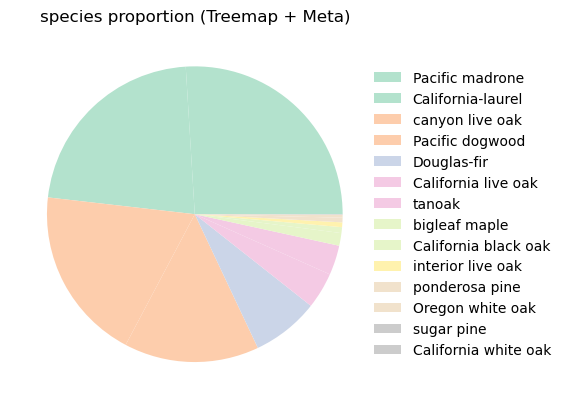

In [41]:
meta_species = fftl_meta_gpd.value_counts('COMMON_NAME', normalize = True).reset_index()

cmap = plt.cm.get_cmap('Pastel2')
colors = [cmap(i) for i in np.linspace(0, 1, meta_species.shape[0])]

plt.pie(meta_species.proportion, colors = colors)
plt.title(f'species proportion (Treemap + Meta)')
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5), labels = meta_species.COMMON_NAME, framealpha = 0)


In [42]:
meta_species

,COMMON_NAME,proportion
0,Pacific madrone,0.259764
1,California-laurel,0.222111
2,canyon live oak,0.190667
3,Pacific dogwood,0.147607
4,Douglas-fir,0.073503
5,California live oak,0.039656
6,tanoak,0.032445
7,bigleaf maple,0.013819
8,California black oak,0.006409
9,interior live oak,0.005207


/var/folders/rp/zdr20wpx60j7227xn_x7mjqc0000gn/T/ipykernel_71624/3836816194.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Pastel2')


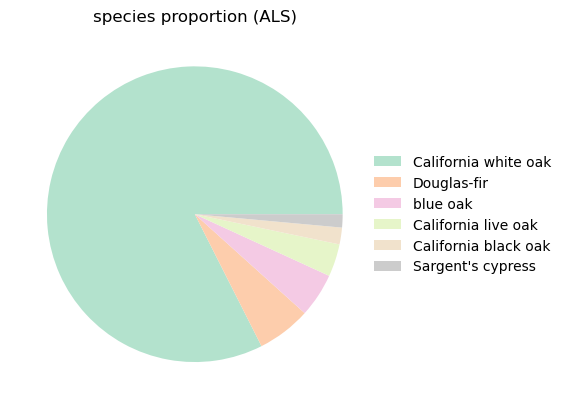

In [43]:
als_species = fftl_als_gpd.value_counts('COMMON_NAME', normalize = True).reset_index()

cmap = plt.cm.get_cmap('Pastel2')
colors = [cmap(i) for i in np.linspace(0, 1, als_species.shape[0])]

plt.pie(als_species.proportion, colors = colors)
plt.title(f'species proportion (ALS)')
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5), labels = als_species.COMMON_NAME, framealpha = 0)


In [44]:
als_species

,COMMON_NAME,proportion
0,California white oak,0.824494
1,Douglas-fir,0.058824
2,blue oak,0.048216
3,California live oak,0.035680
4,California black oak,0.018322
5,Sargent's cypress,0.014465


#### Histograms

In [45]:
def plot_hist(fftl, maintitle):
    
    data1 = fftl.DIA.values / 2.54
    data2 = fftl.HT.values * 3.281
    data3 = fftl.CR.values * 100
    data4 = (1 - fftl.CR.values) * fftl.HT.values * 3.281
    
    all_data = [data1, data2, data3, data4]
    
    titles = ['Diameter (in)', 'Height (ft)', 'Crown Ratio (%)', 'Crown Base Height (ft)']
    xlab_list = ['Diameter (in)', 'Height (ft)', 'Crown Ratio (%)', 'Crown Base Height (ft)']
    
    
    # 2. Create figure and subplots (2 rows, 2 columns)
    fig, axs = plt.subplots(2, 2, 
                            tight_layout=True, 
                            # figsize=(10, 8)
                           )
    # fig, axs = plt.subplots(2, 2)
    # 3. Flatten the axes array for easy iteration
    axs = axs.ravel()
    
    # 4. Loop through data and plot on respective subplots
    for i, ax in enumerate(axs):
        ax.hist(all_data[i], bins=20) # Call hist on the Axes object
        ax.set_title(titles[i])
        ax.set_xlabel(xlab_list[i])
        ax.set_ylabel('Frequency')
    
    fig.suptitle(maintitle)
    # 5. Display the plots
    plt.show()


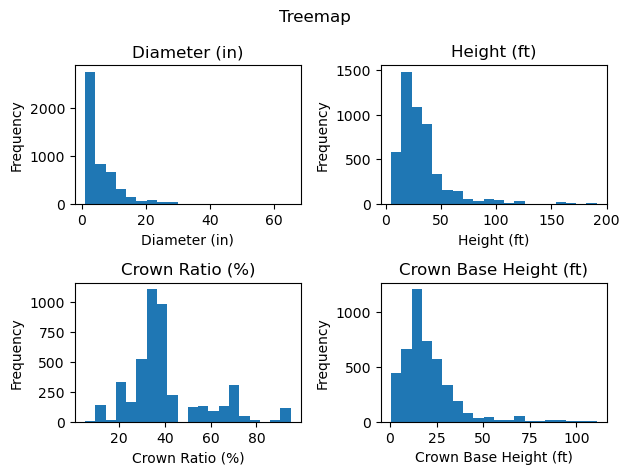

In [46]:
plot_hist(fftl_treemap_gpd, 'Treemap')

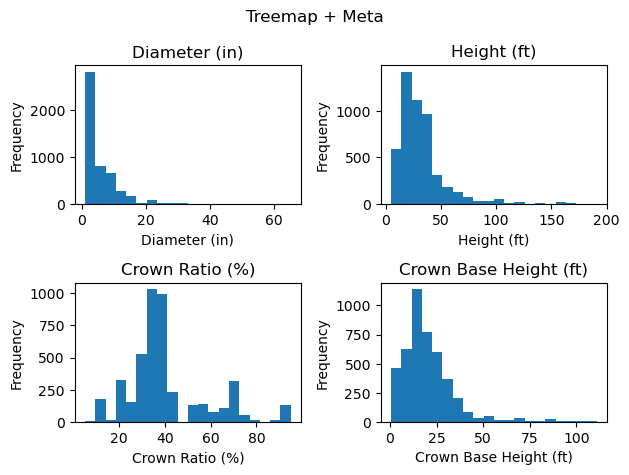

In [47]:
plot_hist(fftl_meta_gpd, 'Treemap + Meta')

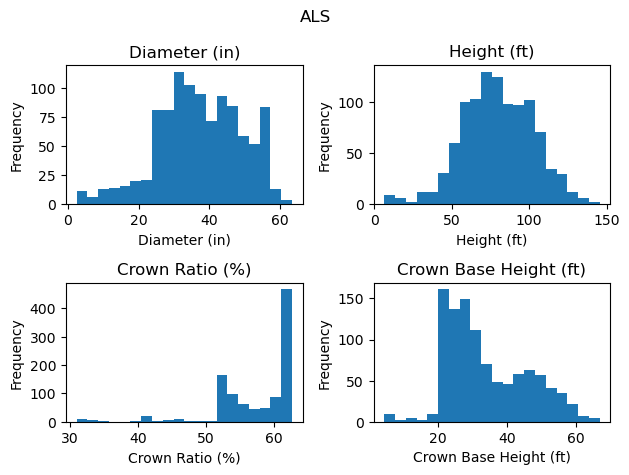

In [48]:
plot_hist(fftl_als_gpd, 'ALS')

#### Bubble plots

In [49]:
# summarize treelist to create bubble plots

def summarize_treelist(fftl):

    #add diameter in inches
    
    fftl['DIA_in'] = fftl['DIA'] / 2.54

    conditions = [
        (fftl['DIA_in'] < 2),
        (fftl['DIA_in'] >= 2) & (fftl['DIA_in'] < 4),
        (fftl['DIA_in'] >= 4) & (fftl['DIA_in'] < 8),
        (fftl['DIA_in'] >= 8) & (fftl['DIA_in'] < 12),
        (fftl['DIA_in'] >= 12) & (fftl['DIA_in'] < 16),
        (fftl['DIA_in'] >= 16) & (fftl['DIA_in'] < 20),
        (fftl['DIA_in'] >= 20)
    ]
    choices = ['0-2', '2-4', '4-8', '8-12', '12-16', '16-20', '20+']
    
    fftl['diam_group'] = np.select(conditions, choices, default='NA')
    fftl['CBH'] = (1 - fftl.CR) * fftl.HT 

    #summarize treelist
    fftl_subset = fftl.groupby(['diam_group'])[['HT', 'CR', 'CBH']].mean().reset_index()

    #add the trees per acre
    domain_size = boundary_5070.area[0]/4047
    
    fftl_subset['TPA'] = fftl.groupby(['diam_group'])['TREE_ID'].count().reset_index()['TREE_ID']/domain_size
    fftl_subset = fftl_subset.set_index('diam_group').reindex(choices).reset_index()
    fftl_subset = fftl_subset.fillna(0)

    return(fftl_subset)

fftl_treemap_subset = summarize_treelist(fftl_treemap_gpd)
fftl_meta_subset = summarize_treelist(fftl_meta_gpd)

fftl_als_gpd['TREE_ID'] = np.arange(fftl_als_gpd.shape[0])
fftl_als_subset = summarize_treelist(fftl_als_gpd)


In [50]:

def bubble_plot(x, y, df, xlabel, ylabel, method):
    choices = ['0-2', '2-4', '4-8', '8-12', '12-16', '16-20', '20+']

    fig, ax = plt.subplots()
    
    scatter = ax.scatter(x, y, 
                edgecolor = 'darkgray',
                s = df.TPA, 
                c =df.index, 
                cmap = 'YlGn')
    handles_c, labels_c = scatter.legend_elements()
    
    # legend for diameter (color)
    legend1 = ax.legend(
        handles_c, 
        choices, 
        loc="upper left", 
        title="Diameter",
        bbox_to_anchor=(1, 0.7)
    )
    ax.add_artist(legend1) # Add the first legend back to the plot
    
    # legend for trees per acre (size)
    handles_s, labels_s = scatter.legend_elements(prop="sizes", alpha=0.6, num=3)
    legend2 = ax.legend(
        handles_s, 
        labels_s, 
        # loc=" left", 
        bbox_to_anchor=(1, 0.9),
        loc = 'center left',
        title="Trees per Acre"
    )
    
    
    # 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"Mean {xlabel} vs Mean {ylabel} - {method}")
    # ax.grid(True)
    
    # plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust the plot area (rect=[left, bottom, right, top])
    plt.show()

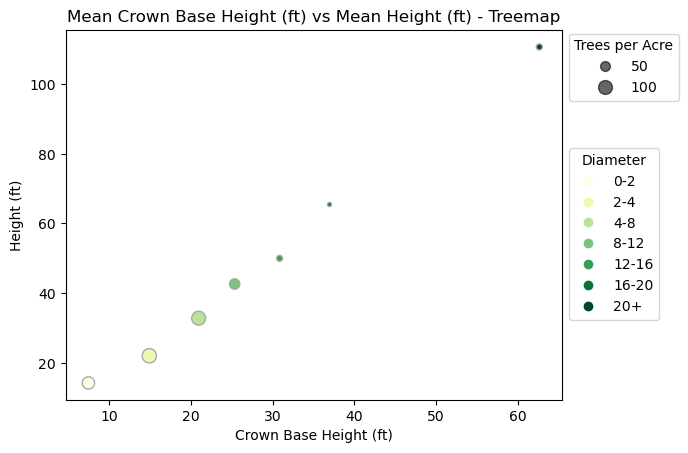

In [51]:
x = fftl_treemap_subset.CBH * 3.281
y = fftl_treemap_subset.HT * 3.281
df = fftl_treemap_subset
xlabel = 'Crown Base Height (ft)'
ylabel = 'Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'Treemap')

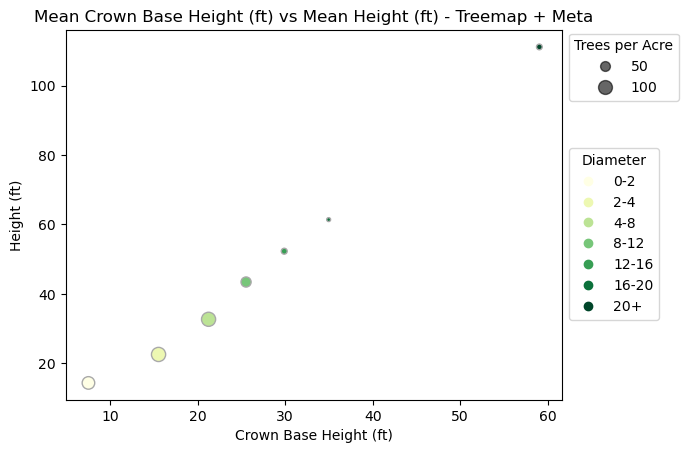

In [52]:
x = fftl_meta_subset.CBH * 3.281
y = fftl_meta_subset.HT * 3.281
df = fftl_meta_subset
xlabel = 'Crown Base Height (ft)'
ylabel = 'Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'Treemap + Meta')

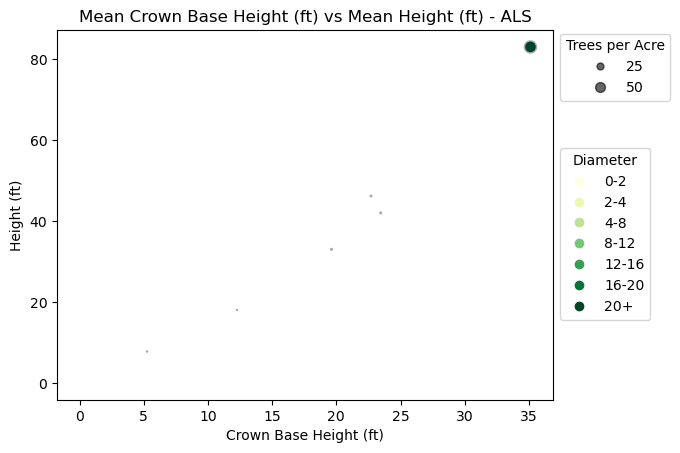

In [53]:
x = fftl_als_subset.CBH * 3.281
y = fftl_als_subset.HT * 3.281
df = fftl_als_subset
xlabel = 'Crown Base Height (ft)'
ylabel = 'Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'ALS')

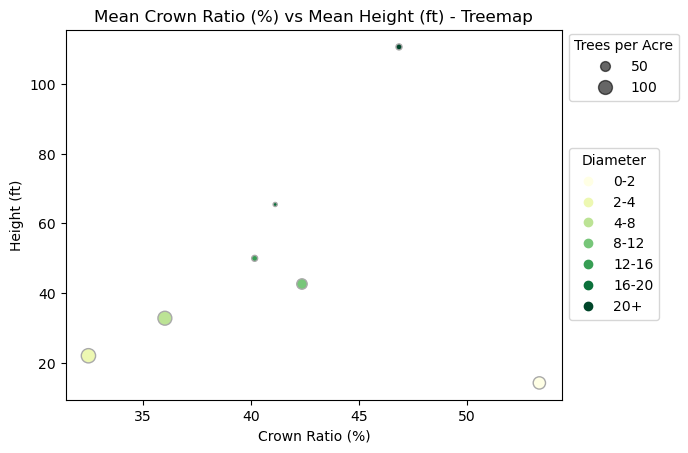

In [54]:
x = fftl_treemap_subset.CR * 100
y = fftl_treemap_subset.HT * 3.281
df = fftl_treemap_subset
xlabel = 'Crown Ratio (%)'
ylabel = 'Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'Treemap')

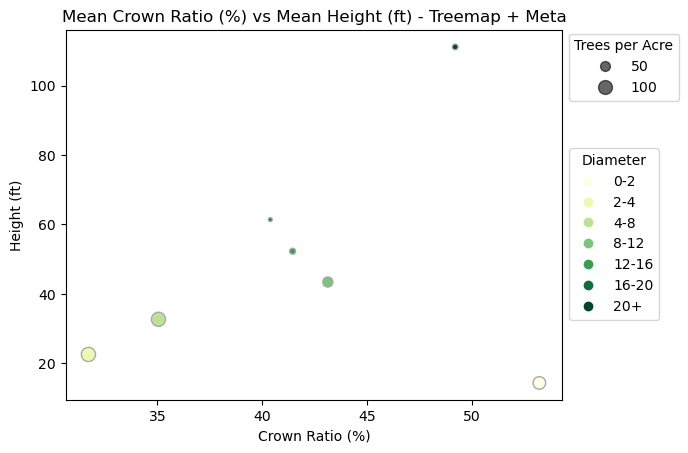

In [55]:
x = fftl_meta_subset.CR * 100
y = fftl_meta_subset.HT * 3.281
df = fftl_meta_subset
xlabel = 'Crown Ratio (%)'
ylabel = 'Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'Treemap + Meta')

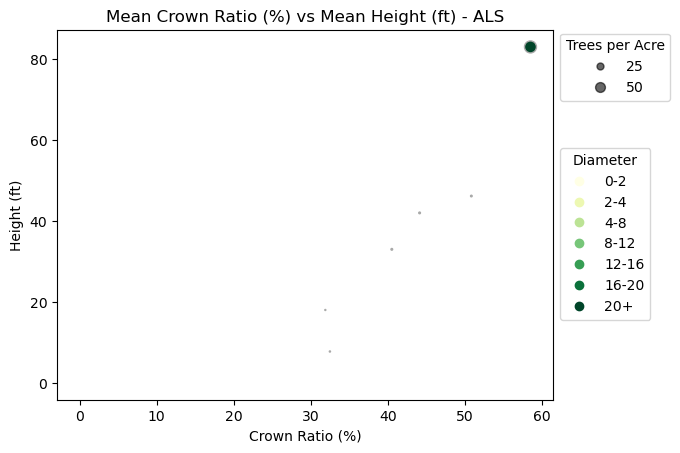

In [56]:
x = fftl_als_subset.CR * 100
y = fftl_als_subset.HT * 3.281
df = fftl_als_subset
xlabel = 'Crown Ratio (%)'
ylabel = 'Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'ALS')

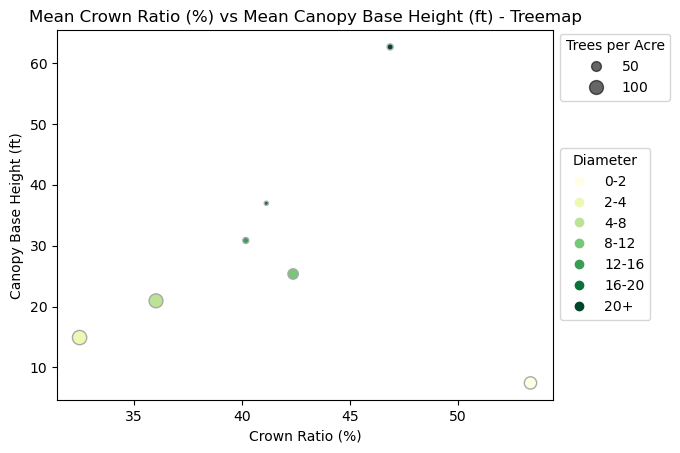

In [57]:
x = fftl_treemap_subset.CR * 100
y = fftl_treemap_subset.CBH * 3.281
df = fftl_treemap_subset
xlabel = 'Crown Ratio (%)'
ylabel = 'Canopy Base Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'Treemap')

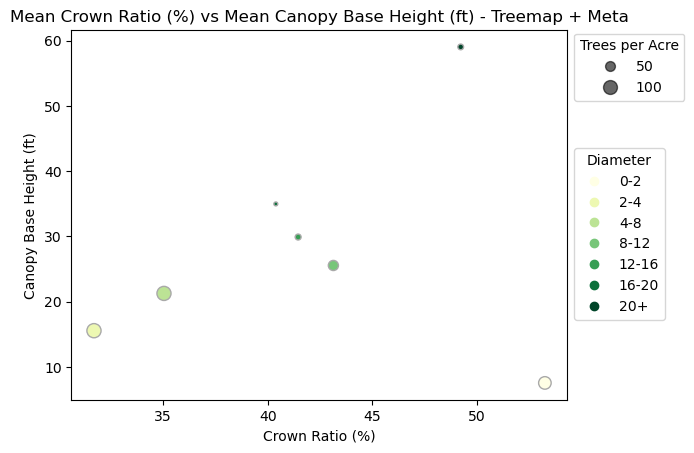

In [58]:
x = fftl_meta_subset.CR * 100
y = fftl_meta_subset.CBH * 3.281
df = fftl_meta_subset
xlabel = 'Crown Ratio (%)'
ylabel = 'Canopy Base Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'Treemap + Meta')

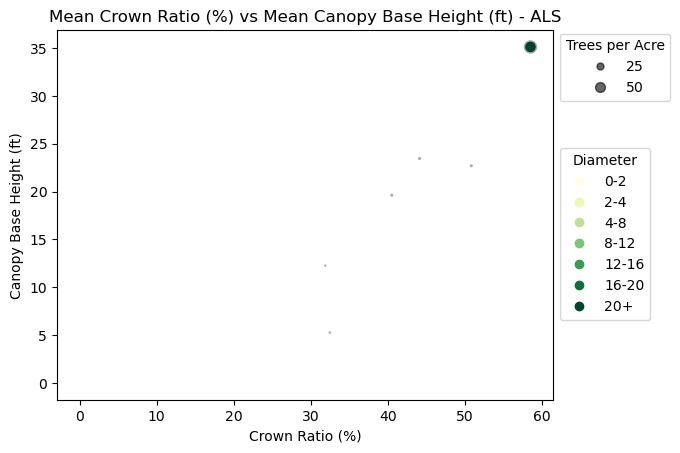

In [59]:
x = fftl_als_subset.CR * 100
y = fftl_als_subset.CBH * 3.281
df = fftl_als_subset
xlabel = 'Crown Ratio (%)'
ylabel = 'Canopy Base Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'ALS')

### Run the Model

Once you have reviewed the fuels layers, you can start the model on BP3D

In [60]:
workflow1.execute()
workflow2.execute()
# workflow3.execute()
workflow4.execute()
workflow5.execute()
# workflow6.execute()


### Access results from BP3D

#### Check BP3D account

Login to BurnPro3D to see the results when they are finished 


In [61]:
# from multiple ensembles, we can go through the runs of each ensemble and extract the outputs using BP3D SDK
ensemble_names = [ensemble_name1, 
                  ensemble_name2, 
                  # ensemble_name3, 
                  ensemble_name4, 
                  ensemble_name5, 
                  # ensemble_name6
                 ]

In [112]:
surface_consumption=[]
midstory_consumption=[]
canopy_consumption=[]
final_viz_url = []

# set up the BP3D Client
c = bp3d.Client(user=user, password=password)

for n, ensemble_name in enumerate(ensemble_names):
    plan = c.plan(ensemble_name)
    ens = plan.ensemble(ensemble_name)
    runs_df = ens.runs_df
    runs_df = runs_df.reset_index()

    viz = runs_df.viz[0]
    viz.sort()
    v = viz[0]
    url = v.split('_')
    t = [int(v.split('_')[4]) for v in viz]
    maxt = max(t)
    final_viz_url.append(f'{url[0]}_{url[1]}_{url[2]}_{url[3]}_{maxt}_{url[5]}')
    
    for i in np.arange(ens.runs_df.shape[0]):
        
        edf = runs_df.iloc[i]
    
        surface_consumption.append(edf.metrics['inside_surface_consumption'])
        midstory_consumption.append(np.sum(edf.metrics['consumption_t0_tNone_z1_z5']))
        canopy_consumption.append(np.sum(edf.metrics['consumption_t0_tNone_z6_zNone']))

In [113]:
pd.DataFrame({'Fuel Tile':ensemble_names,
 'Surface Consumption':surface_consumption,
 'Midstory Consumption': midstory_consumption,
 'Canopy Consumption': canopy_consumption
})

,Fuel Tile,Surface Consumption,Midstory Consumption,Canopy Consumption
0,treemap_landfire PUC 2026-01-14 18:35,0.868331,0.598254,0.048920
1,meta_treemap_landfire PUC 2026-01-14 18:35,0.870253,0.621214,0.072359
2,treemap_fccs PUC 2026-01-14 18:35,0.831139,0.594183,0.069102
3,meta_treemap_fccs PUC 2026-01-14 18:35,0.819603,0.550996,0.066440


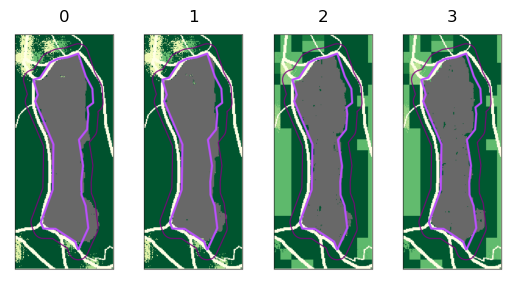

In [116]:
fig, ax = plt.subplots(1, len(ensemble_names))

for n, ensemble_name in enumerate(ensemble_names):
    response = requests.get(final_viz_url[n])
    image = Image.open(BytesIO(response.content))
    
    img = np.array(image)

    ax[n].imshow(img)
    ax[n].set_title(n)
    ax[n].axis('off')
